In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from IPython.display import display

In [2]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
n_control = 4
n_bpm = 3
n_monitor = n_bpm*2
n_task = n_bpm+1
n_state = 3
n_state_pvs = 1

control_CSETs = [f'X{i+1}:I_CSET' for i in range(n_control)]
control_RDs  = [f'X{i+1}:I_RD' for i in range(n_control)]
control_tols = [0.1]*len(control_CSETs)
control_min  = [ 0.0]*len(control_CSETs)
control_max  = [ 1.0]*len(control_CSETs)
bpm_xRDs     = [f'BPM{i}:XPOS_RD' for i in range(n_bpm)]
bpm_magRDs   = [f'BPM{i}:MAG_RD' for i in range(n_bpm)]
monitor_PVs  = bpm_xRDs + bpm_magRDs
state_CSETs  = [f'SLIT{i+1}:POS_CSET' for i in range(n_state_pvs)]
state_RDs    = [f'SLIT{i+1}:POS_RD' for i in range(n_state_pvs)]
state_tols   = [0.1]*len(state_CSETs)
state_min    = [0.0]*n_state_pvs
state_max    = [n_state-1]*n_state_pvs
state_key_vals  = {f'state{s}':[float(s)]*n_state_pvs for s in range(n_state)}
oracle_key_names = {'x':control_RDs,
                    'y':bpm_xRDs + ['BPM:MAG_min_ratio']}
states = list(state_key_vals.keys())

# setup simEPICS

In [4]:
sys.path.append('../../../simEPICS/')
from sim_ioc_lib import create_interactive_ioc, run_ioc_background

input_pv_info = {cset:{'rd':cset.replace('CSET','RD')} for cset in control_CSETs}
for state_set, state_rd in zip(state_CSETs,state_RDs):
    input_pv_info[state_set] = {'rd':state_rd, 'ramping_rate': 0.2}

output_pv_info = {}
for pv in bpm_xRDs:
    output_pv_info[pv] = {'min':-4, 'max':4}
for pv in bpm_magRDs:
    output_pv_info[pv] = {'min':0.7, 'max':1}
    
my_ioc = create_interactive_ioc(input_pv_info, output_pv_info, seed=0)
ioc_loop, ioc_thread = run_ioc_background(my_ioc)

print("IOC running. PVs available:")
for pv in my_ioc.pvdb:
    print(f" - {pv}")

IOC running. PVs available:
 - X1:I_CSET
 - X1:I_RD
 - X2:I_CSET
 - X2:I_RD
 - X3:I_CSET
 - X3:I_RD
 - X4:I_CSET
 - X4:I_RD
 - SLIT1:POS_CSET
 - SLIT1:POS_RD
 - BPM0:XPOS_RD
 - BPM1:XPOS_RD
 - BPM2:XPOS_RD
 - BPM0:MAG_RD
 - BPM1:MAG_RD
 - BPM2:MAG_RD


High load. Batched 5 commands (200B) with 0.0320s latency.
High load. Batched 2 commands (80B) with 0.0310s latency.
High load. Batched 9 commands (360B) with 0.0310s latency.
High load. Batched 6 commands (240B) with 0.0310s latency.
High load. Batched 3 commands (120B) with 0.0310s latency.
High load. Batched 2 commands (80B) with 0.1410s latency.
Exception in thread Thread-5 (_run):
Traceback (most recent call last):
  File "C:\Users\HWANG\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "C:\Users\HWANG\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\HWANG\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\HWANG\My Drive\GitHub\msBO\examples\smoke_test\../../../simEPICS\sim_ioc_lib.py", line 182, in _run
    loop.run_until_compl

### open CSstudio plot

In [5]:
from generate_phoebus_plt import generate_phoebus_plt

monitor_groups = [bpm_xRDs,bpm_magRDs]
control_CSETs_groups = [control_CSETs, state_CSETs]

# Generate and Open
generate_phoebus_plt(
    output_filename="test.plt",
    monitor_groups=monitor_groups,
    control_CSETs_groups=control_CSETs_groups,
    auto_open=True
)

File generated: C:\Users\HWANG\My Drive\GitHub\msBO\examples\smoke_test\test.plt


# setup machineIO

In [6]:
sys.path.append('../../../machineIO/')
from machineIO import construct_machineIO, Evaluator, StatefulOracleEvaluator
io = construct_machineIO()

Failed to import 'phantasy'


# msBO

In [7]:
sys.path.append('../../')
from msBO import MultiStateBO
from msBO.objective import BPMvar_minimization

In [8]:
n_init = 16
n_each = 4
beta = 4

In [9]:
ev= Evaluator(
    io,
    control_CSETs= control_CSETs+state_CSETs,
    control_RDs  = control_RDs+state_RDs,
    control_tols = control_tols+state_tols,
    monitor_PVs = monitor_PVs,
)

In [10]:
x0 = np.random.rand(len(control_CSETs))*(np.asarray(control_max) - np.asarray(control_min)) + np.asarray(control_min)
print("x0",x0)
BPM_MAGs_ref = {}
for s,v in state_key_vals.items():
    future = ev.submit(np.concatenate([x0,v]))
    data, ramping_data = ev.get_result(future)
    y = data[bpm_magRDs].mean().values
    BPM_MAGs_ref[s] = y
BPM_MAGs_ref

x0 [0.36824154 0.95715516 0.14035078 0.87008726]


{'state0': array([0.74241853, 0.97036345, 0.71975592]),
 'state1': array([0.74847322, 0.82166058, 0.71108342]),
 'state2': array([0.99878094, 0.90518233, 1.00128993])}

In [11]:
def BPM_MAG_obj(df,s):
    df['BPM:MAG_min_ratio'] = (df[bpm_magRDs].values/BPM_MAGs_ref[s][None,:]).min()
    return df

In [12]:
oracleEvaluator = StatefulOracleEvaluator(
    io,
    control_CSETs= control_CSETs,
    control_RDs  = control_RDs,
    control_tols = control_tols,
    state_CSETs  = state_CSETs,
    state_RDs    = state_RDs,
    state_tols   = state_tols,
    state_key_vals = state_key_vals,
    oracle_key_names = oracle_key_names,
    monitor_PVs  = monitor_PVs,
    state_df_manipulators = [BPM_MAG_obj],
)

In [13]:
composite_objective_function = BPMvar_minimization(S=n_state, J=n_task)

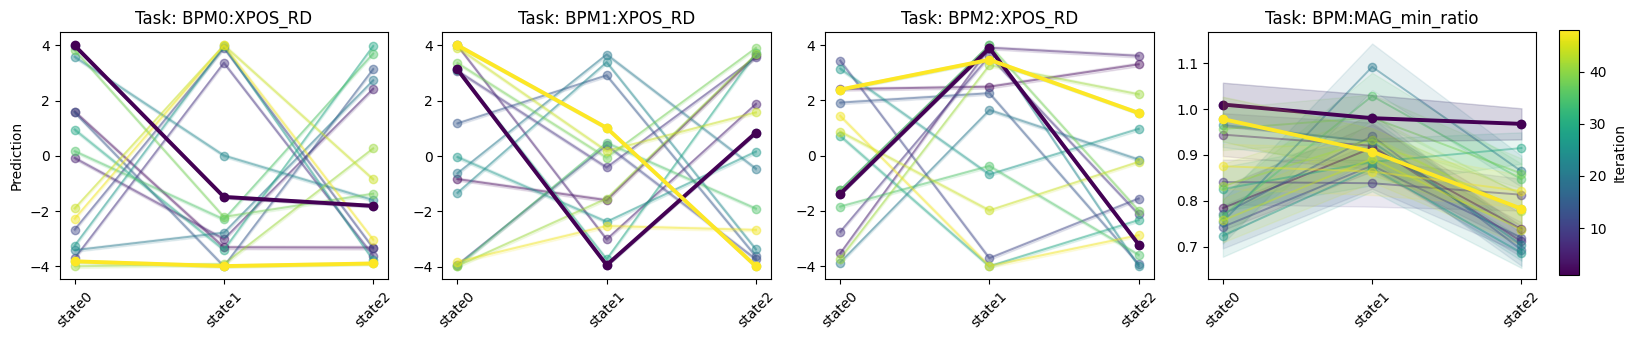

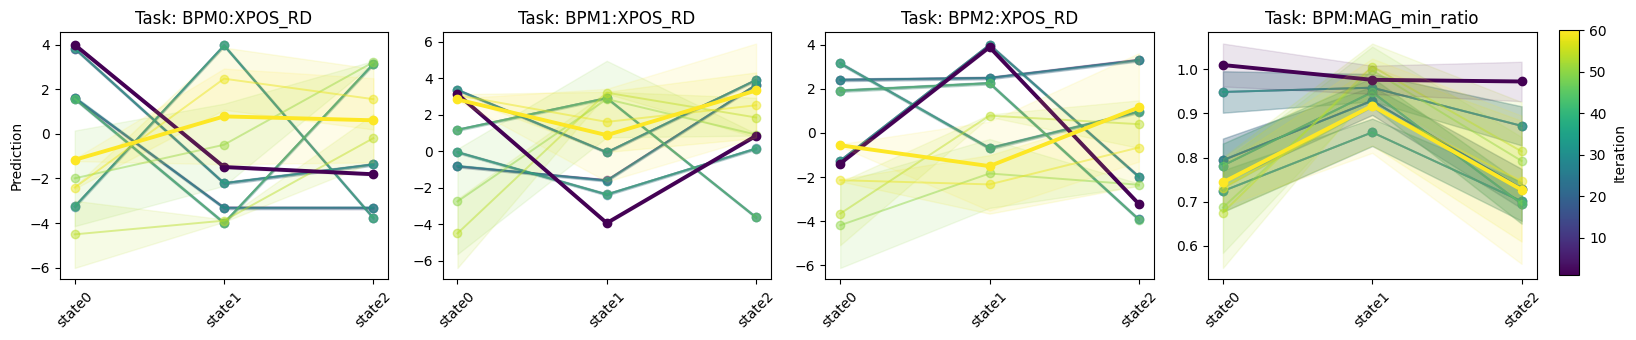

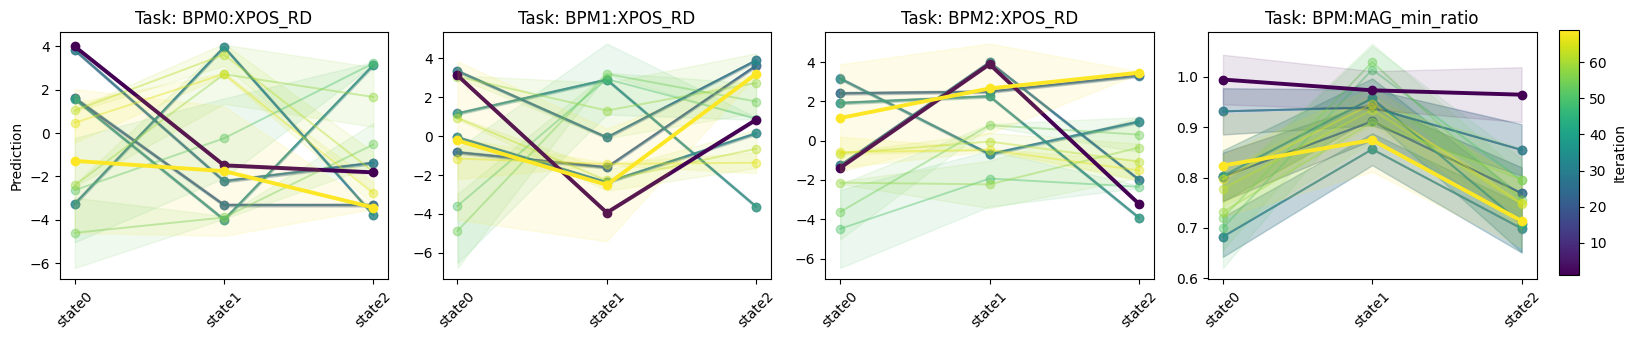

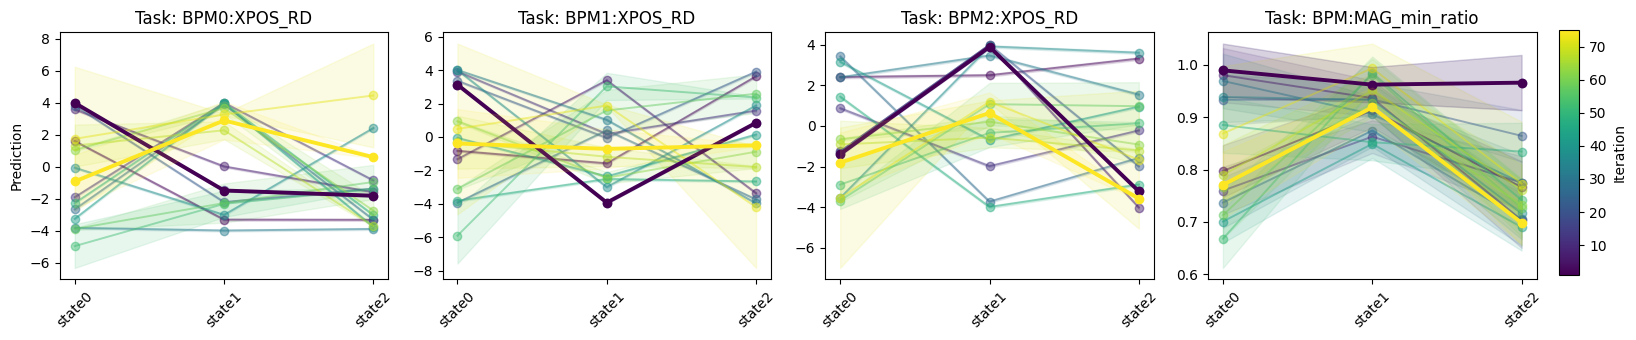

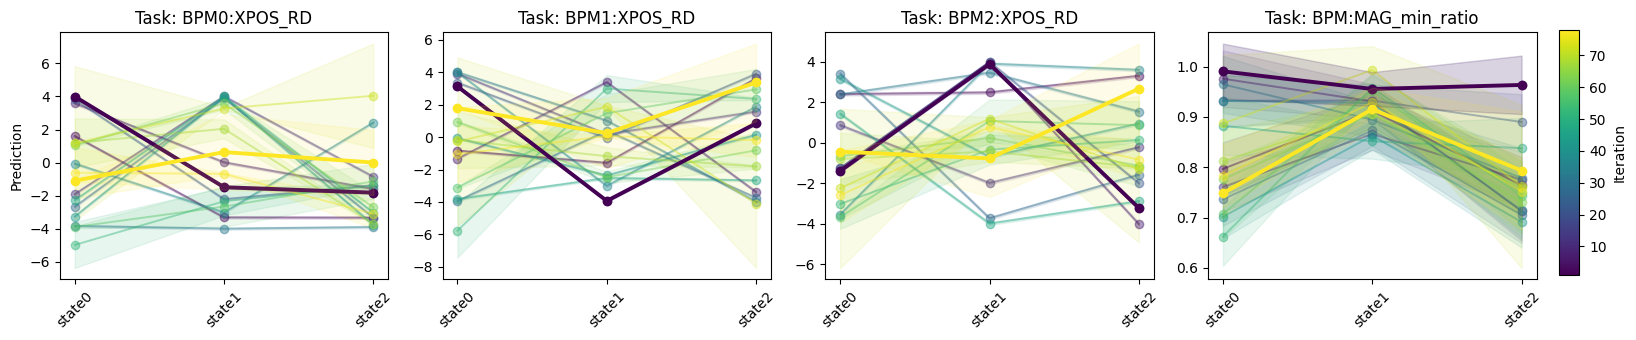

In [14]:
acq_type = 'EI'
fix_acq_state = False
local_optimization=False

np.random.seed(seed)
torch.manual_seed(seed)
oracleEvaluator(x=x0,s=states[0])

msbo = MultiStateBO(
    states = states,
    tasks  = oracle_key_names['y'], 
    control_min = control_min,
    control_max = control_max,
    multistate_oracle_evaluator = oracleEvaluator,
    composite_objective_function = composite_objective_function,
    local_bound_size = 0.1*(np.asarray(control_max) - np.asarray(control_min))
    )
msbo.init(n_init=n_init, local_optimization=local_optimization)
fig, axes = msbo.plot_state_predictions_history()
plt.show()

for s in states[::-1]:
    for i in range(n_each):
        msbo.step(s=s, local_optimization=local_optimization, acq_type=acq_type, fix_acq_state = fix_acq_state, beta=beta)
fig, axes = msbo.plot_state_predictions_history()
plt.show()
for s in states:
    for i in range(n_each-1):
        msbo.step(s=s, local_optimization=local_optimization, acq_type=acq_type, fix_acq_state = fix_acq_state, beta=beta)
fig, axes = msbo.plot_state_predictions_history()
plt.show()
for s in states:
    for i in range(n_each-2):
        msbo.step(s=s, local_optimization=local_optimization, acq_type=acq_type, fix_acq_state = fix_acq_state, beta=beta)
fig, axes = msbo.plot_state_predictions_history()
plt.show()
for s in states[::-1]:
    for i in range(n_each-3):
        msbo.step(s=s, local_optimization=local_optimization, acq_type=acq_type, fix_acq_state = fix_acq_state, beta=beta)
fig, axes = msbo.plot_state_predictions_history()
plt.show()
# iters, means, stds = msbo.virtual_composite_history()

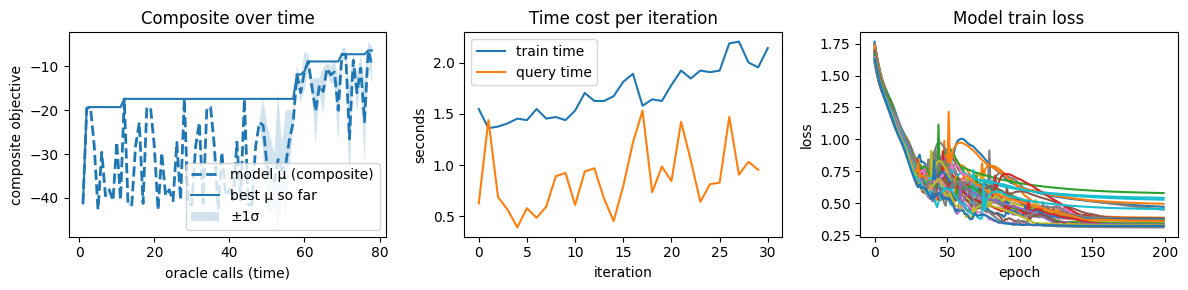

In [15]:
fig,ax, mean = msbo.plot_composite_objective()

In [16]:
fig,ax = msbo.plot_acq_loss_history()

No torch acquisition loss history found.


In [17]:
print("Initiating shutdown...")
ioc_loop.call_soon_threadsafe(ioc_loop.stop)

Initiating shutdown...


<Handle BaseEventLoop.stop()>